# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


## Team:

- **Martín Jurado** .................................................. *A01795568*
- **Lineth Guerra** .................................................. *A01795639*
- **Erick Eduardo Betancourt** ........................... *A01795545*
- **Luis Alejandro González Castellanos** ................. *A01795481*
- **Jesus Armando Anaya Orozco** .................... *A01795464*


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [2]:
# Loading Data
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [4]:
# Extract the labels (target variable) from the training and validation datasets
y_train = np.array(train_df['label'])  # Convert training labels to a NumPy array
y_val = np.array(valid_df['label'])    # Convert validation labels to a NumPy array

# Remove the label column from the training and validation dataframes
del train_df['label']  # Delete the 'label' column from the training data
del valid_df['label']  # Delete the 'label' column from the validation data

# Convert the remaining features in the training and validation sets to NumPy arrays of type float32
x_train = train_df.values.astype(np.float32)  # Convert training features to a float32 NumPy array
x_val = valid_df.values.astype(np.float32)    # Convert validation features to a float32 NumPy array

In [5]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Function to split the validation set into validation and test subsets.

    Parameters:
    - x: numpy array, features of the dataset.
    - y: numpy array, corresponding labels.
    - pct: float, the percentage of the dataset to be used for testing.
    - shuffle: boolean, whether the data should be shuffled before splitting.

    Returns:
    - x_val: numpy array, validation subset of the features.
    - y_val: numpy array, validation subset of the labels.
    - x_test: numpy array, test subset of the features.
    - y_test: numpy array, test subset of the labels.
    '''
    assert 0 < pct < 1, "The percentage must be between 0 and 1"
    
    # Shuffle the data if shuffle is True
    if shuffle:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
    
    # Determine the size of the test subset
    test_size = int(x.shape[0] * pct)
    
    # Split the dataset into validation and test subsets
    x_test = x[:test_size]
    y_test = y[:test_size]
    x_val = x[test_size:]
    y_val = y[test_size:]
    
    return x_val, y_val, x_test, y_test

In [6]:
# Split the validation set into validation and test sets
# This function takes the current validation features and labels and splits them into two sets:
# - x_val, y_val: The new validation features and labels
# - x_test, y_test: The test features and labels
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)


In [7]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

In [8]:
# Calculate the mean and standard deviation of the training data
x_mean = x_train.mean()
x_std = x_train.std()

def normalise(x_mean, x_std, x_data):
    """
    Normalize the input data using the provided mean and standard deviation.
    
    Parameters:
    - x_mean: float, the mean of the dataset.
    - x_std: float, the standard deviation of the dataset.
    - x_data: numpy array, the data to be normalized.
    
    Returns:
    - numpy array, the normalized data.
    """
    return (x_data - x_mean) / x_std

# Apply normalization to training, validation, and test datasets
# Using the mean and std calculated from the training data
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

# Check the mean and standard deviation of the normalized training data
normalized_mean = x_train.mean()
normalized_std = x_train.std()

# Print the results
print(f"Normalized Mean: {normalized_mean:.6f}, Normalized Std: {normalized_std:.6f}")  # This should be approximately 0 and 1, respectively

# Expected results
expected_mean = np.float32(-2.4830147e-08)  # Close to 0
expected_std = np.float32(1.0)  # Close to 1

Normalized Mean: 0.000004, Normalized Std: 0.999999


### Graficar muestras

The sampled image represents: m


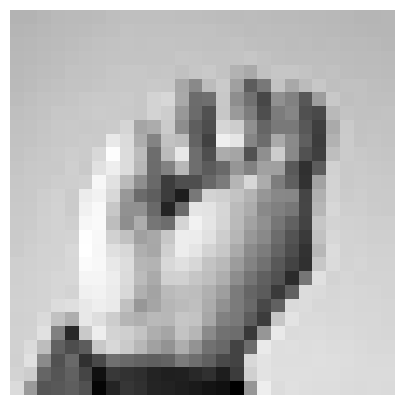

In [9]:
# Function to plot a given image
def plot_number(image):
    plt.figure(figsize=(5, 5))  # Set the figure size
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image in grayscale
    plt.axis('off')  # Turn off the axis to have a cleaner view
    plt.show()  # Show the plotted image

# Randomly sample an index from the test set
rnd_idx = np.random.randint(len(y_test))  # Select a random index from the test labels
print(f'The sampled image represents: {alphabet[y_test[rnd_idx]]}')  # Print the corresponding label by the Alphabet

# Reshape the image if necessary from 784 to 28x28
image_to_plot = x_test[rnd_idx].reshape(28, 28)  # Reshape to the correct dimensions for a 28x28 image

# Plot the image corresponding to the randomly selected index from the test set
plot_number(image_to_plot)  # Use the reshaped image to display


### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [10]:
def create_minibatches(mb_size, x, y, shuffle=True):
    '''
    Create mini-batches from the dataset.
    
    Parameters:
    - mb_size: int, size of each mini-batch.
    - x: numpy array, input data with shape (num_samples, 784).
    - y: numpy array, labels corresponding to the input data with shape (num_samples, 1).
    - shuffle: bool, whether to shuffle the data before creating mini-batches.
    
    Returns:
    - A generator that yields mini-batches of (x_batch, y_batch).
    '''
    
    # Assert that the number of samples in x and y are the same
    assert x.shape[0] == y.shape[0], 'Error: Number of samples in x and y must be equal.'
    
    # Get the total number of samples in the dataset
    total_data = x.shape[0]
    
    # If shuffle is True, shuffle the dataset
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    
    # Generate mini-batches by slicing the dataset
    return ((x[i:i + mb_size], y[i:i + mb_size]) for i in range(0, total_data, mb_size))


## Nuestra clase Linear, ReLU y Sequential

In [11]:
import numpy as np

class np_tensor(np.ndarray):
    pass

# Create a NumPy array and view it as a np_tensor
a = np.array([0, 0])      # Create a standard NumPy array
b = a.view(np_tensor)      # View 'a' as an instance of np_tensor

# Check the types
print(f'Type of a: {type(a)}')  # Should be numpy.ndarray
print(f'Type of b: {type(b)}')  # Should be np_tensor

# Check equality and reference
print(f'a == b: {a == b}')  # Content comparison
print(f'a is b: {a is b}')   # Reference comparison


Type of a: <class 'numpy.ndarray'>
Type of b: <class '__main__.np_tensor'>
a == b: [ True  True]
a is b: False


###  Clase Linear

In [12]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Initialize parameters using He initialization for ReLU activation.
        Parameters:
        - input_size: Number of input features.
        - output_size: Number of output features.
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)  # Weights
        self.b = (np.zeros((output_size, 1))).view(np_tensor)  # Biases

    def __call__(self, X):  # Forward pass
        Z = self.W @ X + self.b  # Linear transformation
        return Z

    def backward(self, X, Z):
        # Backward pass to compute gradients
        X.grad = self.W.T @ Z.grad  # Gradient for input
        self.W.grad = Z.grad @ X.T  # Gradient for weights
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)  # Gradient for bias


### Clase ReLU

In [13]:
class ReLU():
    def __call__(self, Z):
        # Forward pass using ReLU activation
        return np.maximum(0, Z)

    def backward(self, Z, A):
        # Backward pass for ReLU
        Z.grad = A.grad.copy()  # Gradient from the next layer
        Z.grad[Z <= 0] = 0  # Set gradient to 0 for negative inputs


### Clase Sequential

In [14]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        Initialize the sequential model with layers.
        Parameters:
        - layers: List of layers (Linear, ReLU, etc.)
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}

    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)  # Forward pass through each layer
            self.outputs['l'+str(i)] = self.x
        return self.x

    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])  # Backward pass through layers

    def update(self, learning_rate=1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): 
                continue  # Skip updating ReLU layers
            layer.W -= learning_rate * layer.W.grad  # Update weights
            layer.b -= learning_rate * layer.b.grad  # Update biases

    def predict(self, X):
        return np.argmax(self.__call__(X))  # Get predicted class


### Cost Function

In [15]:
def softmaxXEntropy(x, y):
    """
    Compute softmax and cross-entropy cost.

    Parameters:
    - x: Raw scores from the model (logits).
    - y: True labels.

    Returns:
    - preds: Predicted probabilities for each class.
    - cost: Average cross-entropy cost for the batch.
    """
    batch_size = x.shape[1]  # Number of samples in the batch
    exp_scores = np.exp(x)  # Exponentiate the scores
    probs = exp_scores / exp_scores.sum(axis=0)  # Normalize to get probabilities

    # Calculate the predicted probabilities for the true labels
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size  # Average cross-entropy cost

    # Compute gradients for backpropagation
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # Gradient of the loss w.r.t logits
    x.grad = probs.copy()  # Store gradients for backpropagation

    return probs, cost


### Loop de entrenamiento

In [16]:
# Function to train the model and compute accuracy and cost
def train(model, epochs, mb_size=10, learning_rate=1e-3):
    """
    train

    Trains the provided model using mini-batch gradient descent over a specified number of epochs.

    Parameters:
    - model: The model to be trained.
    - epochs (int): The number of complete passes through the training dataset.
    - mb_size (int, optional): The size of each mini-batch. Default is 10.
    - learning_rate (float, optional): The learning rate for updating model weights. Default is 1e-3.

    Returns:
    - val_accuracy (float): The final validation accuracy after training.
    """
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))  # Forward pass
            _, cost = softmaxXEntropy(scores, y)  # Compute cost
            model.backward()  # Backward pass
            model.update(learning_rate)  # Update weights and biases
        
        # Print cost and accuracy at the end of each epoch
        val_accuracy = accuracy(x_val, y_val, mb_size)
        print(f'Epoch {epoch+1}/{epochs} - Cost: {cost}, Accuracy: {val_accuracy}')
    
    # Return the final validation accuracy
    return val_accuracy

def accuracy(x, y, mb_size):
    """
    accuracy

    Computes the accuracy of the model's predictions against the true labels.

    Parameters:
    - x (ndarray): Input data to evaluate predictions.
    - y (ndarray): True labels corresponding to the input data.
    - mb_size (int): The size of each mini-batch for evaluation.

    Returns:
    - (float): The computed accuracy as a fraction of correct predictions to total predictions.
    """
    correct = 0
    total = 0
    for i, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x_batch.T.view(np_tensor))  # Get predictions
        correct += np.sum(np.argmax(pred, axis=0) == y_batch.squeeze())  # Count correct predictions
        total += pred.shape[1]  # Total predictions
    return correct / total  # Return accuracy

### Create your model and train it

In [17]:
# Function to create a new model
def create_model():
    return Sequential_layers([
        Linear(784, 522), ReLU(),  
        Linear(522, 261), ReLU(),  
        Linear(261, 130), ReLU(),  
        Linear(130, 24)   
    ])



# Define the hyperparameter configurations
hyperparameter_configs = [
    (32, 1e-4, 60),   # Small minibatch, moderate learning rate, moderate epochs
    (64, 5e-4, 90),   # Medium minibatch, moderate learning rate, more epochs
    (64, 3e-4, 120)  # Large minibatch, moderate learning rate, many epochs
]

# Variables to store the best model
best_accuracy = 0
best_hyperparams = None
best_model = None

# Iterate over each hyperparameter configuration
for mb_size, learning_rate, epochs in hyperparameter_configs:
    print(f"Training with mb_size: {mb_size}, learning_rate: {learning_rate}, epochs: {epochs}")
    
    # Create a new model for each configuration
    model = create_model()
    
    # Train the model with the specified parameters and get the final accuracy
    final_accuracy = train(model, mb_size=mb_size, learning_rate=learning_rate, epochs=epochs)
    
    # Check if it's the best model
    if final_accuracy > best_accuracy:
        best_accuracy = final_accuracy
        best_hyperparams = (mb_size, learning_rate, epochs)
        best_model = model  # Store the best model

# Print the results of the best model
print(f"\nBest model found with mb_size: {best_hyperparams[0]}, learning_rate: {best_hyperparams[1]}, epochs: {best_hyperparams[2]}")
print(f"Best validation accuracy: {best_accuracy}")

Training with mb_size: 32, learning_rate: 0.0001, epochs: 60
Epoch 1/60 - Cost: 0.6491489267747077, Accuracy: 0.5897936419408812
Epoch 2/60 - Cost: 0.26299872375641054, Accuracy: 0.6807027328499721
Epoch 3/60 - Cost: 0.10729418813858171, Accuracy: 0.7169548243167875
Epoch 4/60 - Cost: 0.09184908581139528, Accuracy: 0.7440044617958729
Epoch 5/60 - Cost: 0.08509277812067899, Accuracy: 0.7490239821528165
Epoch 6/60 - Cost: 0.1302338587927358, Accuracy: 0.7548800892359174
Epoch 7/60 - Cost: 0.03204970744928466, Accuracy: 0.7596207473508088
Epoch 8/60 - Cost: 0.03193323925701438, Accuracy: 0.7621305075292806
Epoch 9/60 - Cost: 0.020422637293733073, Accuracy: 0.7626882320133854
Epoch 10/60 - Cost: 0.015630578797398462, Accuracy: 0.7646402677077524
Epoch 11/60 - Cost: 0.016269798116725867, Accuracy: 0.7649191299498048
Epoch 12/60 - Cost: 0.01734673783013147, Accuracy: 0.7651979921918572
Epoch 13/60 - Cost: 0.014601116172798877, Accuracy: 0.7674288901282766
Epoch 14/60 - Cost: 0.00871656765703

### Test your model on Random data from your test set

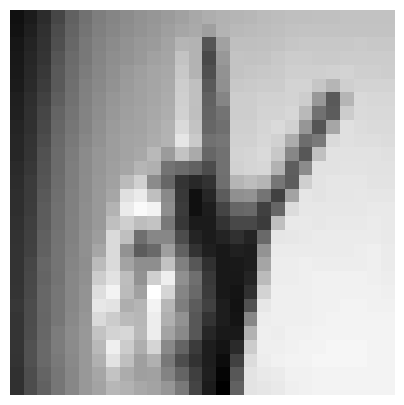

el valor predicho es: w el valor real es:v


In [18]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = best_model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')

### Justification of Model Configuration and Hyperparameters

The hyperparameter configuration and network structure in the model are specifically designed to address the image classification problem of the **ASL (American Sign Language)** dataset on Kaggle, which includes gestures represented by high-dimensional images. Below is the justification for the network architecture and selected hyperparameters:

#### 1. Model Architecture

The model follows a **Fully Connected Network (FCN)** architecture with linear layers and **ReLU** (Rectified Linear Unit) activations, which is suitable for image classification problems.

```python
def create_model():
    return Sequential_layers([
        Linear(784, 522), ReLU(),  
        Linear(522, 261), ReLU(),  
        Linear(261, 130), ReLU(),  
        Linear(130, 24)   
    ])
```

- 784: The number of neurons in the input layer corresponds to the dimensions of the input images (28x28 pixels = 784).
- 522, 261, 130: These hidden layers allow for dimensionality reduction of the information, extracting relevant features across multiple layers.
- ReLU: Introduces non-linearity into the model, allowing it to learn more complex features from the input data.
- 24: The last layer has 24 neurons, one for each letter of the ASL alphabet (except for "J" and "Z").

#### 2. Justification of Hyperparameters

The hyperparameter configurations were selected to achieve a good balance between convergence speed and stability during training.

```python
hyperparameter_configs = [
    (32, 1e-4, 60),   # Small mini-batch, moderate learning rate, moderate epochs
    (64, 5e-4, 90),   # Medium mini-batch, moderate learning rate, more epochs
    (64, 3e-4, 120)   # Large mini-batch, moderate learning rate, many epochs
]
```

##### (32, 1e-4, 60):

- **Mini-batch size (32)**: A small mini-batch allows for frequent weight updates, which helps with convergence.
- **Learning rate (1e-4)**: A moderate value ensures that the model adjusts stably.
- **60 epochs**: A moderate number of epochs to observe the model's behavior without overtraining.

##### (64, 5e-4, 90):

- **Mini-batch size (64)**: Provides greater stability in gradients.
- **Learning rate (5e-4)**: Slightly increases the learning rate to accelerate training.
- **90 epochs**: A higher number of epochs to give the model time to learn better.

##### (64, 3e-4, 120):

- **Mini-batch size (64)**: Maintains gradient stability.
- **Learning rate (3e-4)**: A good balance between convergence rate and stability.
- **120 epochs**: Allows the model to refine its weights for a longer time.

### General Justification in the Context of the ASL Dataset

- ASL Dataset: This dataset has more complex images compared to MNIST, requiring more layers and neurons to capture complex patterns.

- Mini-batch size: A small size (32) allows for more frequent parameter adjustments, which is useful for learning complex features. Medium and large sizes (64) offer greater stability and accuracy.

- Learning rate: Moderate learning rates (1e-4, 5e-4, 3e-4) help avoid abrupt fluctuations and allow the model to adjust its weights efficiently.

- Number of epochs: Since the ASL dataset is more complex, a higher number of epochs is needed to allow the model to learn adequately without overfitting.

### Conclusion

The proposed model and hyperparameter configuration are designed to address the specific challenges of the ASL dataset. The deep network architecture with linear layers and ReLU activations allows for extracting important features from the gesture images. The selected hyperparameters balance the need for rapid convergence with stability and accuracy in learning.